Number of examples (rows): 165
Number of features (columns): 10002
type
HCC       69.69697
normal    30.30303
Name: proportion, dtype: float64
Number of examples (rows): 165
Number of features (columns): 10000


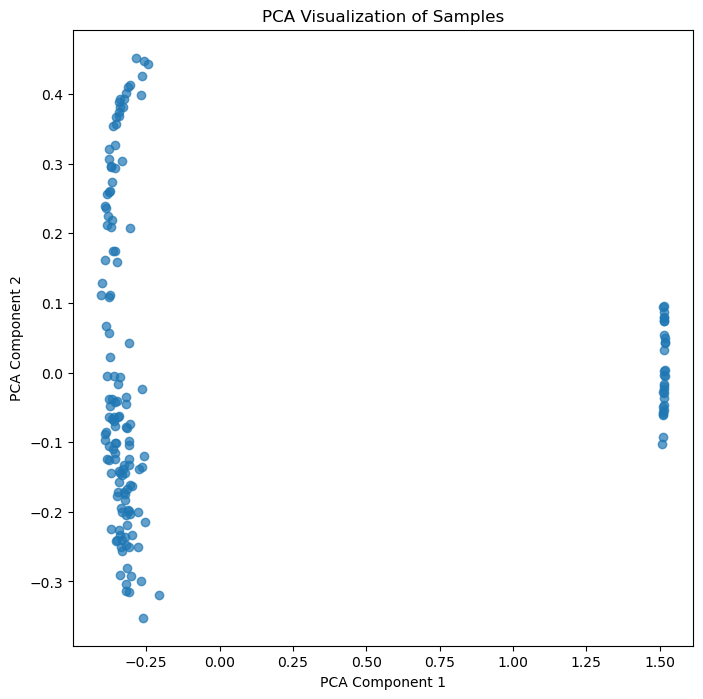

In [50]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


df = pd.read_csv("liver_cancer_expression_data.csv") 
# df = df.dropna(axis=1)
# print(df.head())
# print(df.isnull().sum())  
nExamples, nFeatures = df.shape
print(f"Number of examples (rows): {nExamples}")
print(f"Number of features (columns): {nFeatures}")
print(df["type"].value_counts(normalize=True) * 100)

X = df.drop(columns=["type"])
X = X.iloc[:, 1:]
y = df["type"]

imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X = (X - X.mean()) / X.std()
X = normalize(X, axis=1) 
nExamples, nFeatures = X.shape
print(f"Number of examples (rows): {nExamples}")
print(f"Number of features (columns): {nFeatures}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Samples")
plt.show()

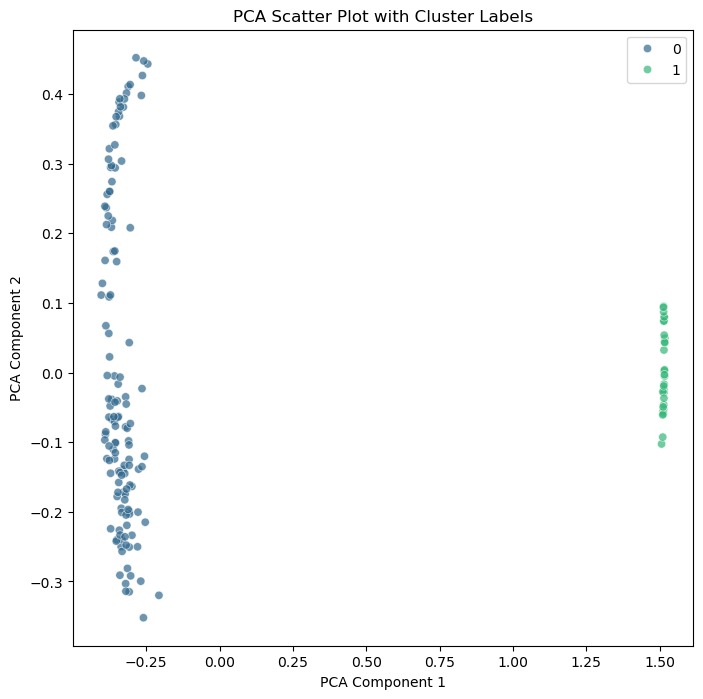

In [41]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Scatter Plot with Cluster Labels")
plt.show()

Removed 30 samples from the smaller group.


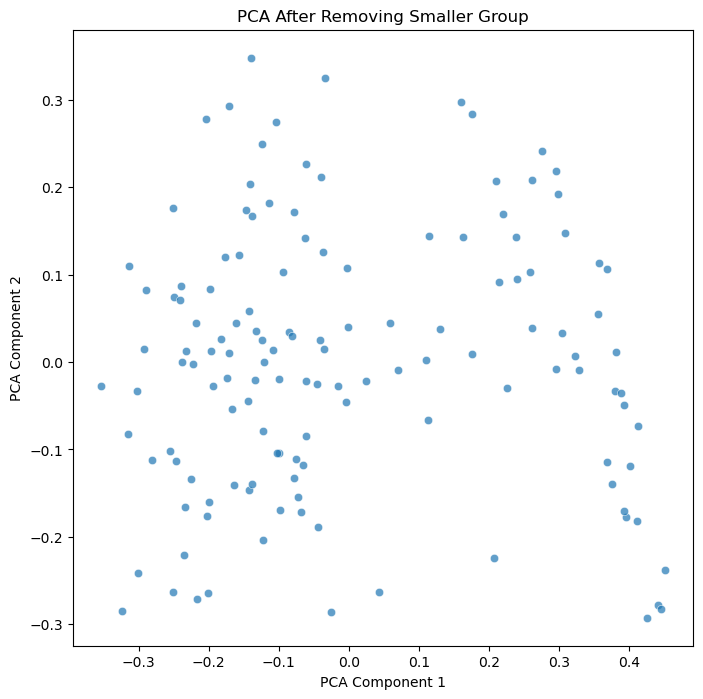

Number of examples (rows): 135
Number of features (columns): 10000
type
HCC       71.851852
normal    28.148148
Name: proportion, dtype: float64


In [52]:
import numpy as np

unique, counts = np.unique(clusters, return_counts=True)
cluster_counts = dict(zip(unique, counts))
smallest_cluster = min(cluster_counts, key=cluster_counts.get)
X_filtered = X[clusters != smallest_cluster]
y_filtered = y[clusters != smallest_cluster]
print(f"Removed {cluster_counts[smallest_cluster]} samples from the smaller group.")
X_pca_filtered = pca.fit_transform(X_filtered)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_pca_filtered[:, 0], y=X_pca_filtered[:, 1], alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA After Removing Smaller Group")
plt.show()

nExamples, nFeatures = X_filtered.shape
print(f"Number of examples (rows): {nExamples}")
print(f"Number of features (columns): {nFeatures}")
print(y_filtered.value_counts(normalize=True) * 100)

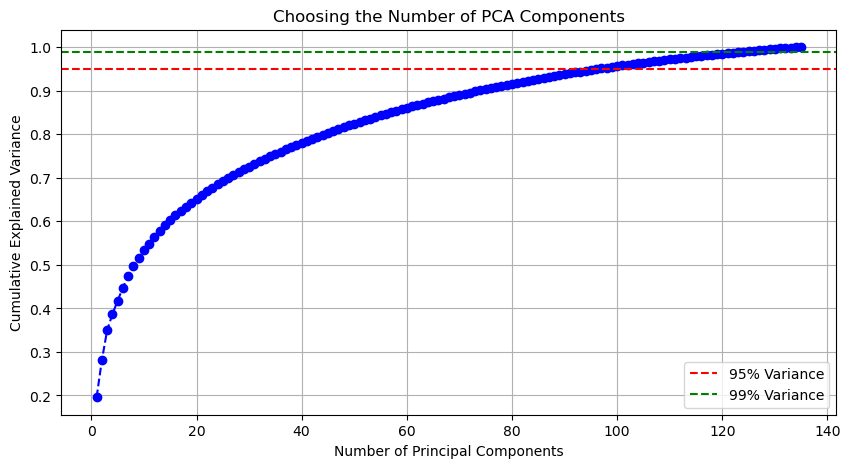

Number of examples (rows): 135
Number of features (columns): 97
type
HCC       71.851852
normal    28.148148
Name: proportion, dtype: float64


In [57]:
from sklearn.preprocessing import StandardScaler

pca = PCA()
pca.fit(X_filtered)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance")
plt.axhline(y=0.99, color='g', linestyle='--', label="99% Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Choosing the Number of PCA Components")
plt.legend()
plt.grid(True)
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1 
pca = PCA(n_components=n_components_95)  # Replace with chosen value
X_reduced = pca.fit_transform(X_filtered)

nExamples, nFeatures = X_reduced.shape
print(f"Number of examples (rows): {nExamples}")
print(f"Number of features (columns): {nFeatures}")
print(y_filtered.value_counts(normalize=True) * 100)

In [64]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_rbf, X_reduced, y_filtered, cv=cv, scoring="accuracy")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Mean Accuracy: 0.9481 ± 0.0181


In [65]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10, 100],  # regularization
    "gamma": ["scale", 0.01, 0.1, 1, 10]  # kernel co-eff
}
grid_search = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_reduced, y_filtered)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

Best Parameters: {'C': 1, 'gamma': 'scale'}
Best CV Accuracy: 0.9481
